In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

[Auto MPG dataset from UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

<img src="https://archive.ics.uci.edu/ml/assets/MLimages/Large9.jpg" alt="drawing" width="800"/>


In [2]:
df_auto = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
                      delimiter=r"\s+",
                      header=None,
                      names=["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin","car name"])

In [3]:
df_auto

mpg  cylinders  displacement horsepower  weight  acceleration  \
0    18.0          8         307.0      130.0  3504.0          12.0   
1    15.0          8         350.0      165.0  3693.0          11.5   
2    18.0          8         318.0      150.0  3436.0          11.0   
3    16.0          8         304.0      150.0  3433.0          12.0   
4    17.0          8         302.0      140.0  3449.0          10.5   
..    ...        ...           ...        ...     ...           ...   
393  27.0          4         140.0      86.00  2790.0          15.6   
394  44.0          4          97.0      52.00  2130.0          24.6   
395  32.0          4         135.0      84.00  2295.0          11.6   
396  28.0          4         120.0      79.00  2625.0          18.6   
397  31.0          4         119.0      82.00  2720.0          19.4   

     model year  origin                   car name  
0            70       1  chevrolet chevelle malibu  
1            70       1          buick skylark 320  
2            70       1         plymouth satellite  
3            70       1              amc rebel sst  
4            70       1                ford torino  
..          ...     ...                        ...  
393          82       1            ford mustang gl  
394          82       2                  vw pickup  
395          82       1              dodge rampage  
396          82       1                ford ranger  
397          82       1                 chevy s-10  

[398 rows x 9 columns]

### Simple Data Inspection

#### Data subsetting
Let's make the life simpler to use only 3 variables to predict the mpg

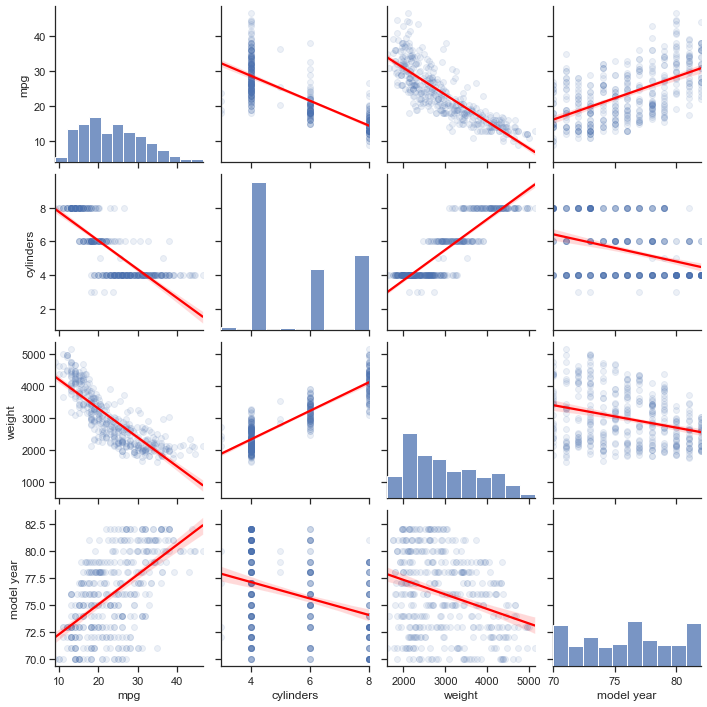

In [4]:
df_auto_gb = df_auto[["mpg", "cylinders", "weight", "model year"]]
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df_auto_gb, kind="reg", 
                 plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

In [5]:
df_auto_gb.describe()

mpg   cylinders       weight  model year
count  398.000000  398.000000   398.000000  398.000000
mean    23.514573    5.454774  2970.424623   76.010050
std      7.815984    1.701004   846.841774    3.697627
min      9.000000    3.000000  1613.000000   70.000000
25%     17.500000    4.000000  2223.750000   73.000000
50%     23.000000    4.000000  2803.500000   76.000000
75%     29.000000    8.000000  3608.000000   79.000000
max     46.600000    8.000000  5140.000000   82.000000

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

### Train-test splitting

In [7]:
np.random.seed(2020)
mask = np.random.rand(len(df_auto_gb)) < 0.7
df_auto_gb_train = df_auto_gb[mask]
df_auto_gb_test = df_auto_gb[~mask]

### Prototyping Classes

In [8]:
class weak_learner:
    def __init__(self, learning_rate = 1):
        self.model = DecisionTreeRegressor(max_depth=2, random_state = 0)
        self.learning_rate = learning_rate # omit for now
    def predict(self,X):
        return self.learning_rate * self.model.predict(X)
    def fit(self,X,y):
        return self.model.fit(X,y)
    def plot(self):
        tree.plot_tree(self.model)

class strong_learner:
    def __init__(self):
        self.wls = []
        self.num_wls = 0
    def predict(self,X, max_iter = None):
        predictions = np.zeros(X.shape[0])
        if max_iter == None:
            for wl in self.wls:
                predictions += wl.predict(X)
        else:
            for i, wl in enumerate(self.wls):
                if i == max_iter:
                    break
                predictions += wl.predict(X)
        return predictions
    def iterate(self,wl):
        self.wls.append(wl)
        self.num_wls += 1

class learner_0:
    def __init__(self,mean_value):
        self.mean_value = mean_value
    def predict(self,X):
        return np.array([self.mean_value for _ in range(X.shape[0])])

## Train

### First round
Obtain the *initial* residual.

**I will keep track of these residuals and following predictions as new columns of the DataFrame.**

In [9]:
%%capture
residual_0 = df_auto_gb_train["mpg"] - np.mean(df_auto_gb_train["mpg"])
df_auto_gb_train["residual_0"] = residual_0

In [10]:
df_auto_gb_train

mpg  cylinders  weight  model year  residual_0
2    18.0          8  3436.0          70   -5.822807
3    16.0          8  3433.0          70   -7.822807
4    17.0          8  3449.0          70   -6.822807
5    15.0          8  4341.0          70   -8.822807
6    14.0          8  4354.0          70   -9.822807
..    ...        ...     ...         ...         ...
393  27.0          4  2790.0          82    3.177193
394  44.0          4  2130.0          82   20.177193
395  32.0          4  2295.0          82    8.177193
396  28.0          4  2625.0          82    4.177193
397  31.0          4  2720.0          82    7.177193

[285 rows x 5 columns]

In [11]:
training_features = ["cylinders","weight","model year"]

In [12]:
wl_0 = learner_0(np.mean(df_auto_gb_train["mpg"]))

First weak learner simply returns the mean.

In [13]:
wl_0.predict(df_auto_gb_train)[0:10]

array([23.82280702, 23.82280702, 23.82280702, 23.82280702, 23.82280702,
       23.82280702, 23.82280702, 23.82280702, 23.82280702, 23.82280702])

Add it to the strong learner

In [14]:
strong_learner_gb = strong_learner()
strong_learner_gb.iterate(wl_0)

#### Training the strong learner for the **first** iteration.


In [15]:
wl_1 = weak_learner(1)
wl_1.fit(df_auto_gb_train[training_features],df_auto_gb_train["residual_0"])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

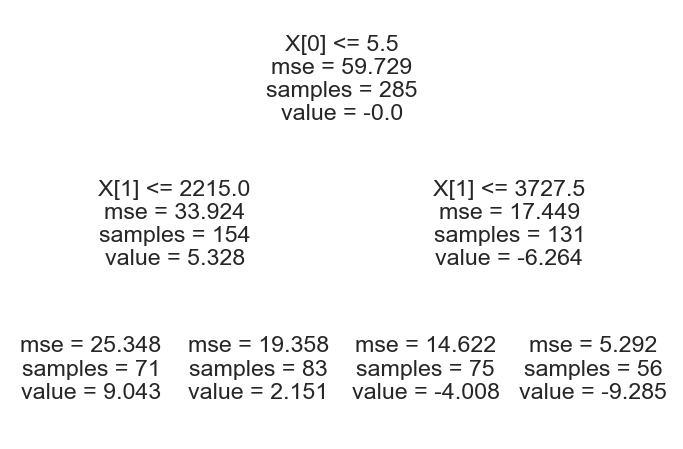

In [16]:
plt.figure(figsize=(12,8))
wl_1.plot()

#### Add the first non-trivial weak learner to strong learner

In [17]:
strong_learner_gb.iterate(wl_1)

#### See how our strong learner's perform

In [18]:
prediction_1 = strong_learner_gb.predict(df_auto_gb_train[training_features])

In [19]:
%%capture
df_auto_gb_train["prediction_1"] = prediction_1
df_auto_gb_train["residual_1"] = df_auto_gb_train["mpg"] - prediction_1

#### Compare the true value and the predicted value
The ideal situation will be a diagonal line

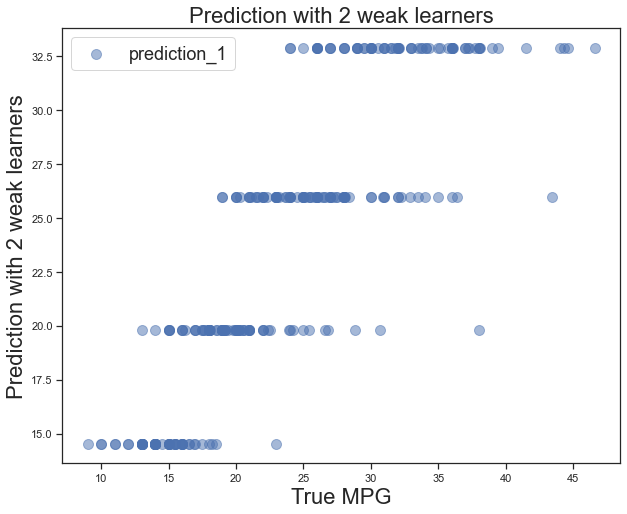

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(df_auto_gb_train["mpg"],prediction_1, label= "prediction_1",alpha=0.5,
                s=100)
plt.legend(fontsize=18)
plt.xlabel("True MPG", fontsize=22)
plt.ylabel("Prediction with {} weak learners".format(strong_learner_gb.num_wls), fontsize=22)
plt.title("Prediction with {} weak learners".format(strong_learner_gb.num_wls), fontsize=22);

### Perform one more iteration

In [21]:
wl_2 = weak_learner(1)
wl_2.fit(df_auto_gb_train[training_features],df_auto_gb_train["residual_1"])

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [22]:
%%capture
strong_learner_gb.iterate(wl_2)
prediction_2 = strong_learner_gb.predict(df_auto_gb_train[training_features])
df_auto_gb_train["prediction_2"] = prediction_2
df_auto_gb_train["residual_2"] = df_auto_gb_train["mpg"] - prediction_2

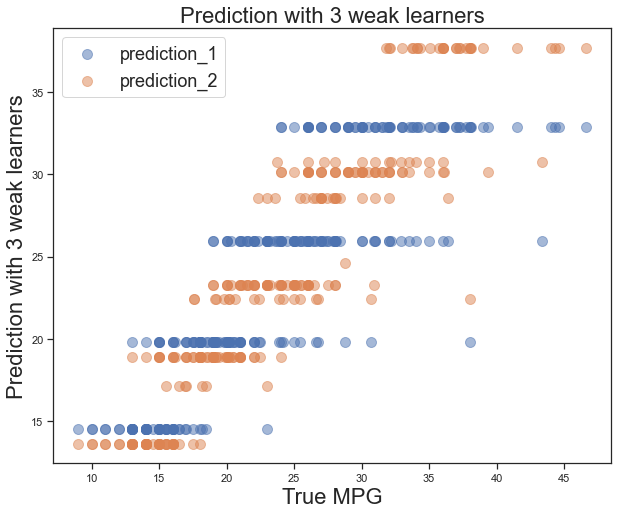

In [23]:
plt.figure(figsize=(10,8))
plt.scatter(df_auto_gb_train["mpg"],prediction_1, label= "prediction_1",alpha=0.5,
                s=100)
plt.scatter(df_auto_gb_train["mpg"],prediction_2, label= "prediction_2",alpha=0.5,
                s=100)
plt.legend(fontsize=18)
plt.xlabel("True MPG", fontsize=22)
plt.ylabel("Prediction with {} weak learners".format(strong_learner_gb.num_wls), fontsize=22);
plt.title("Prediction with {} weak learners".format(strong_learner_gb.num_wls), fontsize=22);

### Iterate for 50 times

In [24]:
%%capture
for j in range(3,51):
    wl_temp = weak_learner(1)
    wl_temp.fit(df_auto_gb_train[training_features],df_auto_gb_train["residual_{}".format(j-1)])
    strong_learner_gb.iterate(wl_temp)
    prediction_temp = strong_learner_gb.predict(df_auto_gb_train[training_features])
    df_auto_gb_train["prediction_{}".format(j)] = prediction_temp
    df_auto_gb_train["residual_{}".format(j)] = df_auto_gb_train["mpg"] - prediction_temp

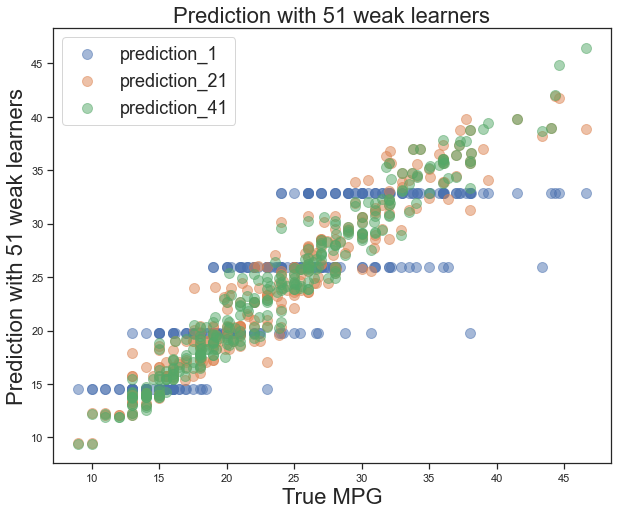

In [25]:
plt.figure(figsize=(10,8))
for j in range(1,50,20):
    plt.scatter(df_auto_gb_train["mpg"],
                df_auto_gb_train["prediction_{}".format(j)], 
                label= "prediction_{}".format(j),
                alpha=0.5,
                s=100)
plt.legend(fontsize=18)
plt.xlabel("True MPG", fontsize=22)
plt.ylabel("Prediction with {} weak learners".format(strong_learner_gb.num_wls), fontsize=22)
plt.title("Prediction with {} weak learners".format(strong_learner_gb.num_wls), fontsize=22);

#### Examine the residuals

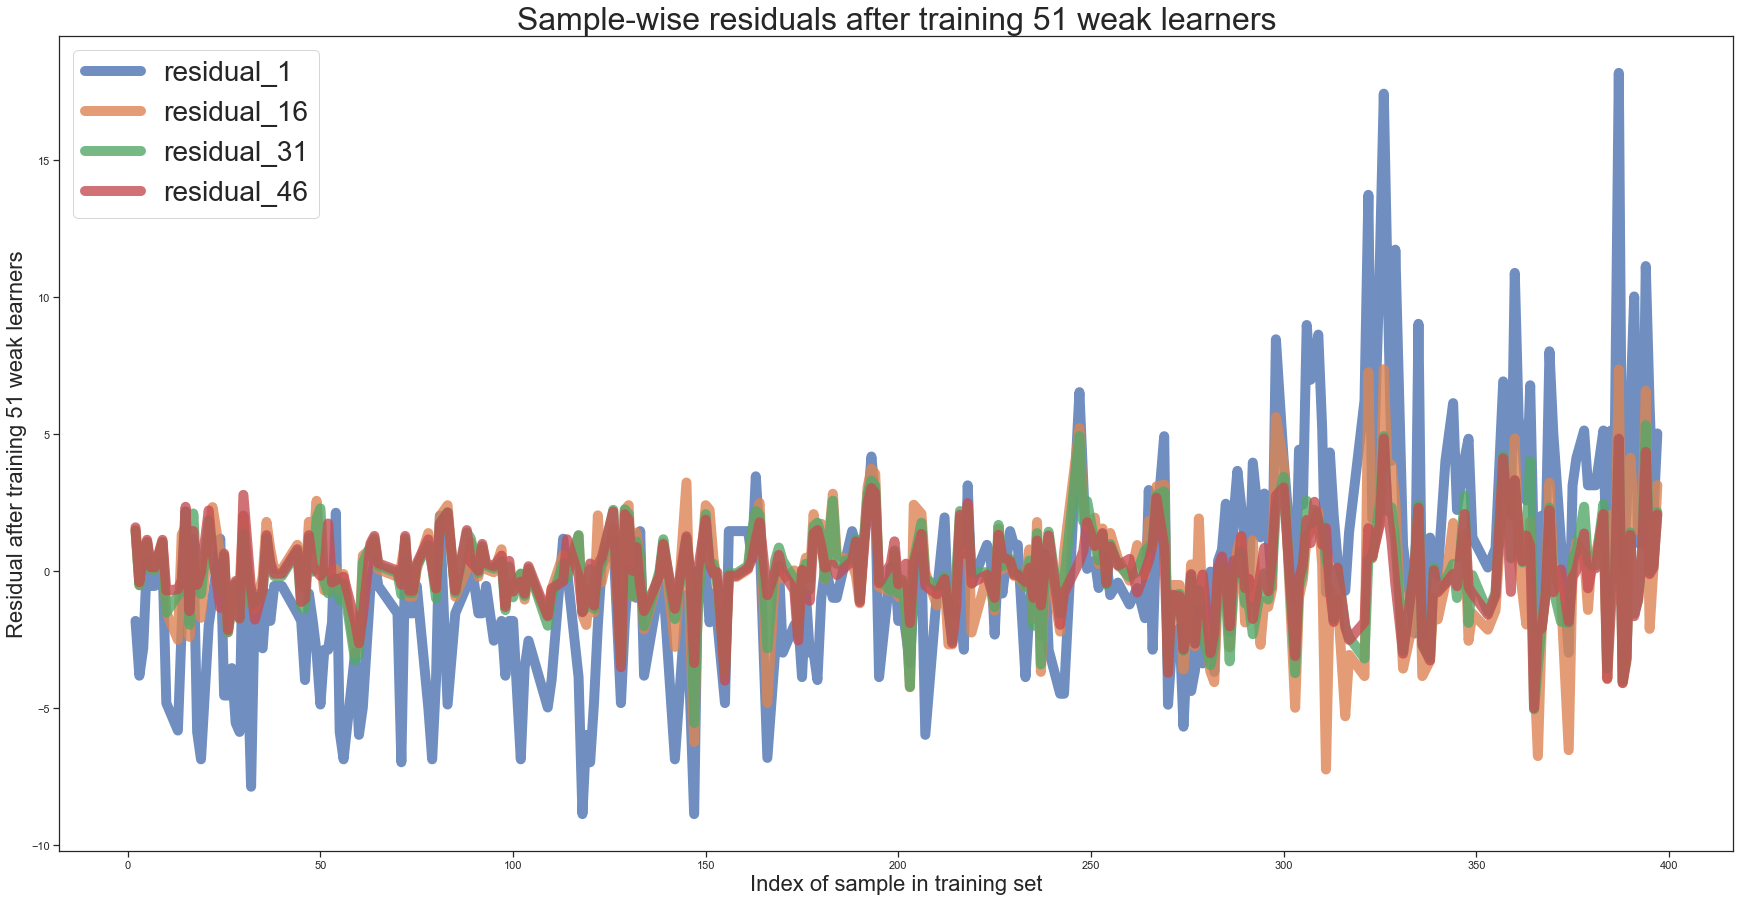

In [26]:
plt.figure(figsize=(30,15))
for j in range(1,50,15):
    plt.plot(df_auto_gb_train["residual_{}".format(j)], 
                label= "residual_{}".format(j), linewidth=10,alpha = 0.8)
plt.legend(fontsize=28)
plt.xlabel("Index of sample in training set", fontsize=22)
plt.ylabel("Residual after training {} weak learners".format(strong_learner_gb.num_wls), fontsize=22)
plt.title("Sample-wise residuals after training {} weak learners".format(strong_learner_gb.num_wls), fontsize=32);

In [27]:
from sklearn.metrics import mean_squared_error

## Performance on Test set

In [28]:
%%capture
iterations = range(1,strong_learner_gb.num_wls)
errors_train = []
errors_test = []
for j in range(1,strong_learner_gb.num_wls):
    errors_train.append(mean_squared_error(df_auto_gb_train["mpg"],df_auto_gb_train["prediction_{}".format(j)]))
    df_auto_gb_test["prediction_{}".format(j)] = strong_learner_gb.predict(df_auto_gb_test[training_features],j)
    errors_test.append(mean_squared_error(df_auto_gb_test["mpg"],df_auto_gb_test["prediction_{}".format(j)]))

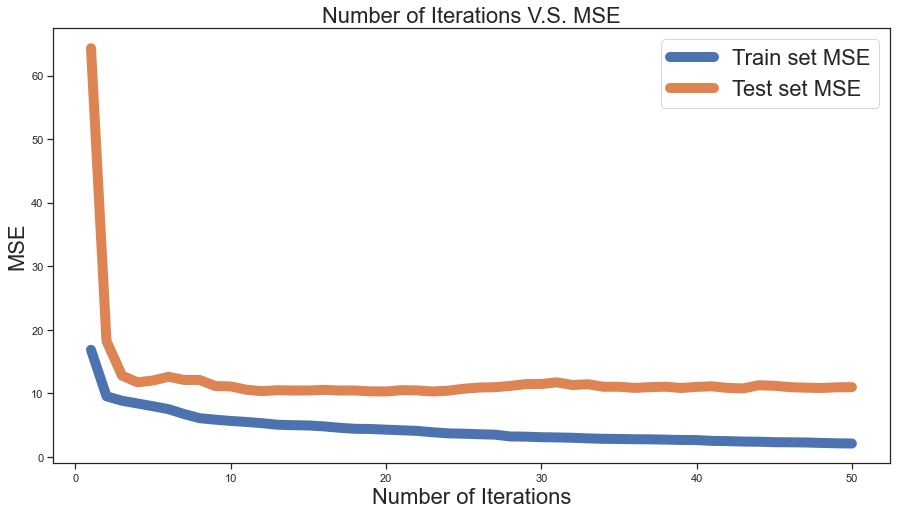

In [29]:
plt.figure(figsize=(15,8))
plt.plot(iterations,errors_train,label="Train set MSE", linewidth=10)
plt.plot(iterations,errors_test,label="Test set MSE", linewidth=10)
plt.legend(fontsize=22)
plt.xlabel("Number of Iterations", fontsize=22)
plt.ylabel("MSE", fontsize=22)
plt.title("Number of Iterations V.S. MSE", fontsize=22);

### Compare the result with a **single** deep regression tree with increasing number of max depth

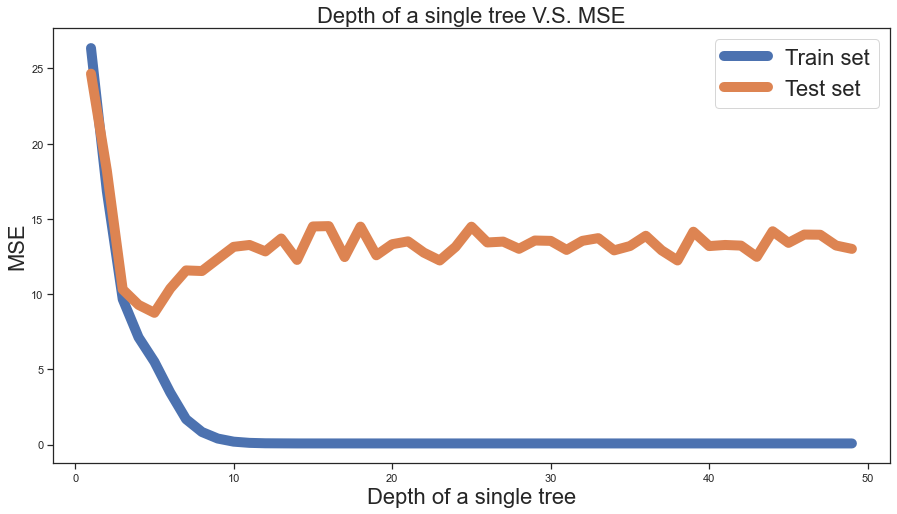

In [30]:
dt_train_mse = []
dt_test_mse = []
depths = 50
for i in range(1,depths):
    deep_tree = DecisionTreeRegressor(max_depth=i)
    deep_tree.fit(df_auto_gb_train[training_features],df_auto_gb_train["mpg"])
    train_mse = mean_squared_error(deep_tree.predict(df_auto_gb_train[training_features]), df_auto_gb_train["mpg"])
    test_mse = mean_squared_error(deep_tree.predict(df_auto_gb_test[training_features]),df_auto_gb_test["mpg"])
    dt_train_mse.append(train_mse)
    dt_test_mse.append(test_mse)

plt.figure(figsize=(15,8))
plt.plot(range(1,depths), dt_train_mse, label="Train set", linewidth = 10)
plt.plot(range(1,depths), dt_test_mse, label= "Test set", linewidth = 10)
plt.legend(fontsize=22)
plt.xlabel("Depth of a single tree", fontsize=22)
plt.ylabel("MSE", fontsize=22)
plt.title("Depth of a single tree V.S. MSE", fontsize=22);

#### It is clear that the almost errorless performance on the training set is an illusion as the tree is overfitting.


### Visualizing some trees


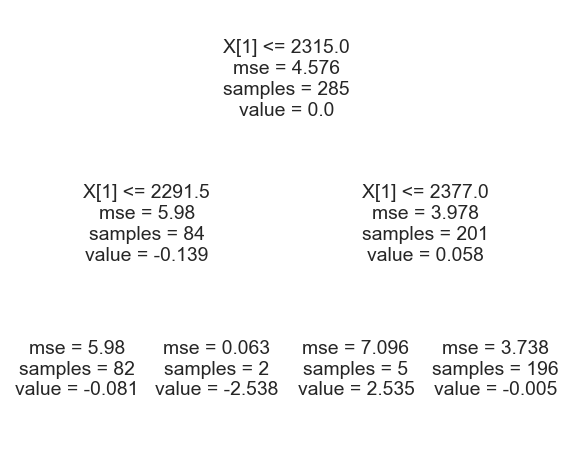

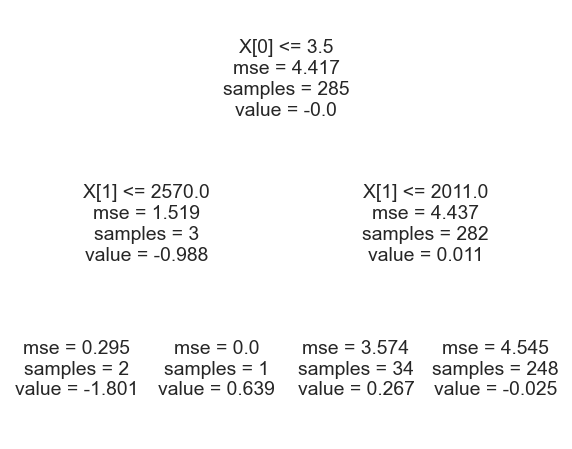

In [31]:
for i, wl in enumerate(strong_learner_gb.wls):
    if  i > 17 and i < 20:
        plt.figure(figsize=(10,8))
        wl.plot()
        plt.show()

Used [external codes](https://stackoverflow.com/questions/43929400/retrieve-decision-boundary-lines-x-y-coordinate-format-from-sklearn-decision-t) to visualize the decision boundaries of selected trees.

In [32]:
from collections import deque
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree as ctree
from matplotlib.patches import Rectangle


class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right


def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i])
            queue.extend([l, r])
    return aabbs


def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    return rectangles

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['g', 'r'][int(rect[4])]
        # print(rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.3)
        rp.set_ec("r")
        rp.set_linewidth(5)
        plt.gca().add_artist(rp)

In [33]:
import time

### Let's visualize the cylinder [4, 8] and weight [2000, 5000]'s influence

In [34]:
%%capture
for i in range(1,45): 
    rectangles = decision_areas(strong_learner_gb.wls[i].model, [3, 9, 1500, 5200], x=0, y=1)
    plt.figure(figsize=(10,10))
    plt.scatter(df_auto_gb_train["cylinders"], 
                df_auto_gb_train["weight"],
                s = 10*df_auto_gb_train["mpg"],
                alpha=0.5)
    plot_areas(rectangles)
    plt.xlabel("Cylinders")
    plt.ylabel("Weight")
    plt.title("Decision boundaries for tree {}".format(i), 
              fontdict={"fontsize":20});
    plt.savefig("tree{}.jpg".format(i))

Let's create a gif from the saved data.

In [36]:
import imageio
from glob import glob
filenames = sorted(glob("tree*.jpg"), key = lambda x: int(x.split(".")[0][4:]))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gd_trees.gif', images, duration=0.5)

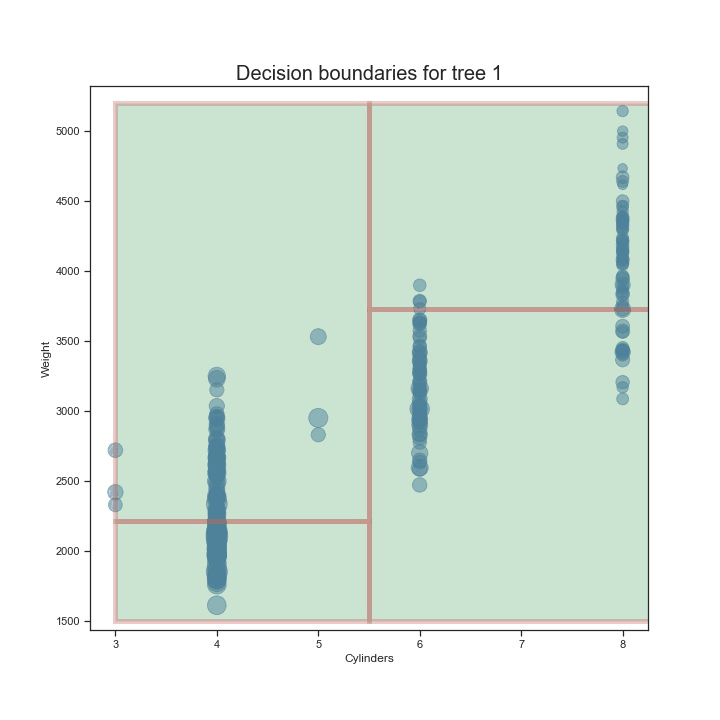

In [37]:
from IPython.display import Image
Image(open('gd_trees.gif','rb').read())

How about the single deep decision tree?

In [38]:
%%capture
for i in range(2,11):
    deep_tree = DecisionTreeRegressor(max_depth=i,random_state=0)
    deep_tree.fit(df_auto_gb_train[training_features],df_auto_gb_train["mpg"])
    rectangles = decision_areas(deep_tree, [3, 9, 1500, 5200], x=0, y=1)
    plt.figure(figsize=(10,10))
    plt.scatter(df_auto_gb_train["cylinders"], 
                df_auto_gb_train["weight"],
                s = 10*df_auto_gb_train["mpg"],
                alpha=0.5)
    plot_areas(rectangles)
    plt.xlabel("Cylinders")
    plt.ylabel("Weight")
    plt.title("Decision Boundaries for a Single Deep Decision Tree with depth {}".format(i),
              fontdict={"fontsize":20})
    plt.savefig("deep{}.jpg".format(i))

In [39]:
filenames = sorted(glob("deep*.jpg"), key = lambda x: int(x.split(".")[0][4:]))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('single_deep.gif', images, duration=0.5)

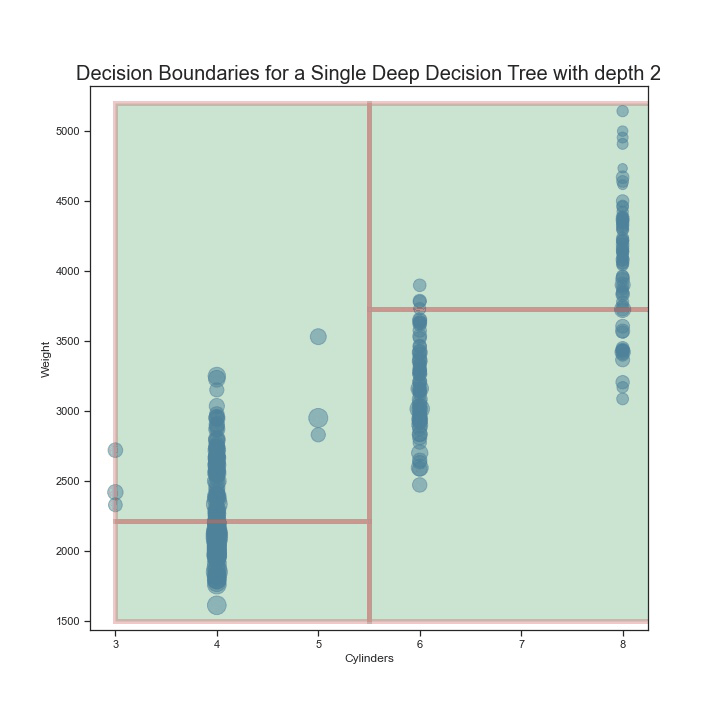

In [40]:
Image(open('single_deep.gif','rb').read())

### Why is gradient boosting not easy to overfit?* 
<img src="https://w7.pngwing.com/pngs/370/535/png-transparent-person-thinking-illustration-question-mark-animation-question-text-cartoon-desktop-wallpaper.png" alt="drawing" width="70"/>

From the animation above, you can see that a single decision tree might overfit and continue refining the minute structures. On the other hand, the boosted trees might overfit at a local region but they will also underfit somewhere else.

## Influence of Learning rate*
#### Strictly speaking, there is a difference between multiplier/coefficient and learning rate. The multipliers/coefficients are subject to optimization. See the general algorithm below.

#### **This is left to you as an exercies.**

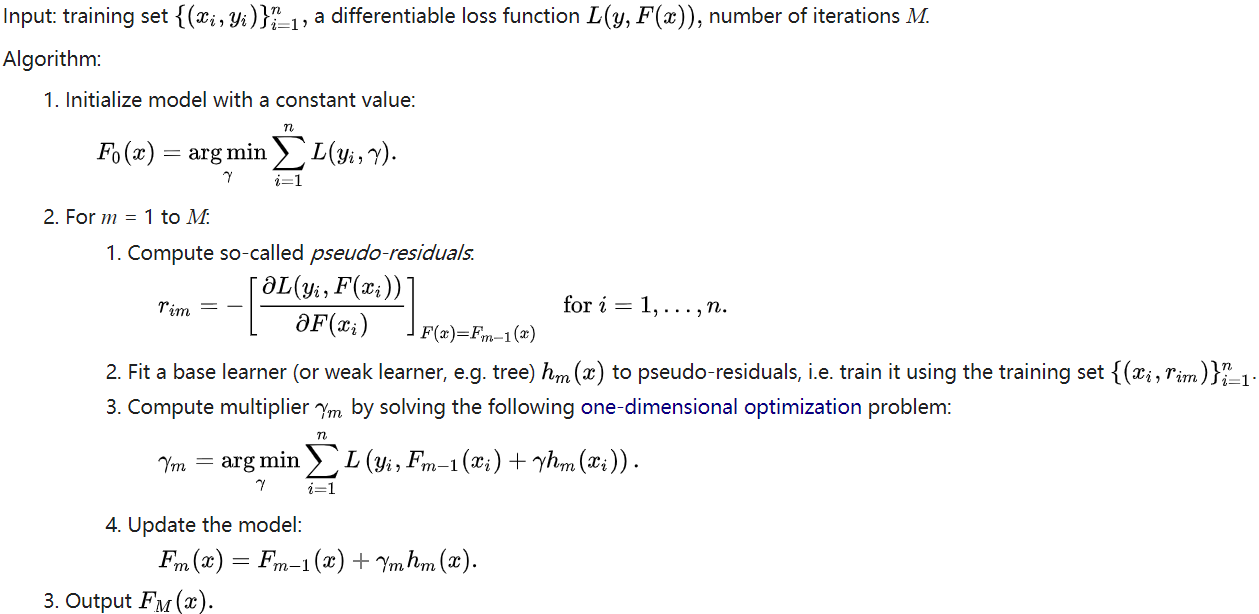